In [2]:
import numpy as np
import pandas as pd
import librosa
import os
import glob
import re
import seaborn as sn
import matplotlib.pyplot as plt
import scipy
import time
import collections
import keras
from keras.utils import np_utils
from keras.layers import MaxPooling1D, Conv1D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, CuDNNLSTM, Attention
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
import pickle
from keras.utils.vis_utils import plot_model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Bidirectional, Attention, ELU, LSTM, SimpleRNN, Input, ConvLSTM2D, BatchNormalization, MaxPooling3D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from numpy import array


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

encoder = OneHotEncoder(sparse=False)

### Method for extracting indexes out of filenames

In [3]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """

    # Synth lead borttagen. id = 9
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        print("Oops")
        return None

### Get training data

In [3]:
train_dir = "CustomDataFull/traindata10000.pkl"

with open(train_dir, 'rb') as f:
    X_train_full = pickle.load(f)

X_train = []
y_train = []

for(key, value) in X_train_full.items():
    X_train.append(value)
    y_train.append(instrument_code(key))
y_train_numpy = np.asarray(y_train)
X_train_numpy = np.asarray(X_train)
  
print(y_train_numpy.shape)

example = array(y_train_numpy)
encoder = OneHotEncoder(sparse=False)
example = example.reshape(len(example), 1)
onehot_encoded = encoder.fit_transform(example)
y_train_numpy = onehot_encoded

(87500,)


/home/stenmarken/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Get validation data

In [4]:
valid_dir = "CustomDataFull/validdata2000.pkl"

with open(valid_dir, 'rb') as f:
    X_valid_full = pickle.load(f)

X_valid = []
y_valid = []

for(key, value) in X_valid_full.items():
    #temporal_value = np.mean(value, axis = 1)
    X_valid.append(value)
    y_valid.append(instrument_code(key))
y_valid_numpy = np.asarray(y_valid)
X_valid_numpy = np.asarray(X_valid)

print(X_valid_numpy.shape)
print(y_valid_numpy.shape)

example = array(y_valid_numpy)
encoder = OneHotEncoder(sparse=False)
example = example.reshape(len(example), 1)
onehot_encoded = encoder.fit_transform(example)
y_valid_numpy = onehot_encoded

(12678, 126, 13)
(12678,)


/home/stenmarken/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Get testing data

In [4]:
test_dir = "CustomDataFull/testdata2000.pkl"

with open(test_dir, 'rb') as f:
    X_test_full = pickle.load(f)

X_test = []
y_test = []
for(key, value) in X_test_full.items():
    X_test.append(value)
    y_test.append(instrument_code(key))
y_test_numpy = np.asarray(y_test)
X_test_numpy = np.asarray(X_test)

# Spara värdena som icke-one hot encodad för att kunna använda dem i vår confusion matrix
y_test_confusion = y_test_numpy
X_test_confusion = y_test_numpy

example = array(y_test_numpy)
encoder = OneHotEncoder(sparse=False)
example = example.reshape(len(example), 1)
onehot_encoded = encoder.fit_transform(example)
y_test_numpy = onehot_encoded

/home/stenmarken/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Implementation of the LSTM

In [6]:
optimizer = Adam(clipvalue=0.5, learning_rate=0.0001)
n_classes = 10

model = Sequential()
#model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True), input_shape=(126, 128)))
#model.add(CuDNNLSTM(4, input_shape=(126, 128), return_sequences=True))
#model.add(Dropout(0.5))
model.add(LSTM(32, input_shape=(126, 13), return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=True))
#model.add(Dropout(0.3))
#model.add(LSTM(16, return_sequences=True))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

2023-04-24 17:47:11.566315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:47:11.571676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:47:11.571902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 17:47:11.573303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 126, 32)           5888      
                                                                 
 lstm_1 (LSTM)               (None, 126, 32)           8320      
                                                                 
 flatten (Flatten)           (None, 4032)              0         
                                                                 
 dense (Dense)               (None, 10)                40330     
                                                                 
Total params: 54,538
Trainable params: 54,538
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(x=X_train_numpy, y=y_train_numpy, validation_data=(X_valid_numpy, y_valid_numpy), batch_size=10, epochs=30, verbose=2, shuffle=True)

Epoch 1/30


2023-04-24 17:47:38.102019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2023-04-24 17:47:39.664972: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd1cc740270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-24 17:47:39.665003: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2023-04-24 17:47:39.668631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-24 17:47:39.757422: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8750/8750 - 79s - loss: 1.6423 - accuracy: 0.4011 - val_loss: 1.7163 - val_accuracy: 0.3973 - 79s/epoch - 9ms/step
Epoch 2/30
8750/8750 - 72s - loss: 1.3274 - accuracy: 0.5238 - val_loss: 1.5506 - val_accuracy: 0.4438 - 72s/epoch - 8ms/step
Epoch 3/30
8750/8750 - 75s - loss: 1.1923 - accuracy: 0.5723 - val_loss: 1.5063 - val_accuracy: 0.4836 - 75s/epoch - 9ms/step
Epoch 4/30
8750/8750 - 74s - loss: 1.1014 - accuracy: 0.6049 - val_loss: 1.4376 - val_accuracy: 0.4979 - 74s/epoch - 8ms/step
Epoch 5/30
8750/8750 - 75s - loss: 1.0377 - accuracy: 0.6266 - val_loss: 1.5071 - val_accuracy: 0.5215 - 75s/epoch - 9ms/step
Epoch 6/30
8750/8750 - 77s - loss: 0.9878 - accuracy: 0.6441 - val_loss: 1.5133 - val_accuracy: 0.5305 - 77s/epoch - 9ms/step
Epoch 7/30
8750/8750 - 75s - loss: 0.9516 - accuracy: 0.6543 - val_loss: 1.3991 - val_accuracy: 0.5659 - 75s/epoch - 9ms/step
Epoch 8/30
8750/8750 - 77s - loss: 0.9136 - accuracy: 0.6692 - val_loss: 1.3934 - val_accuracy: 0.5743 - 77s/epoch - 9ms/step
Epo

# Testing

128/128 [==============================] - 1s 3ms/step
[0 4 3 ... 8 8 0]
[0 4 3 ... 8 8 0]
['loss', 'accuracy']
[1.6314194202423096, 0.64306640625]


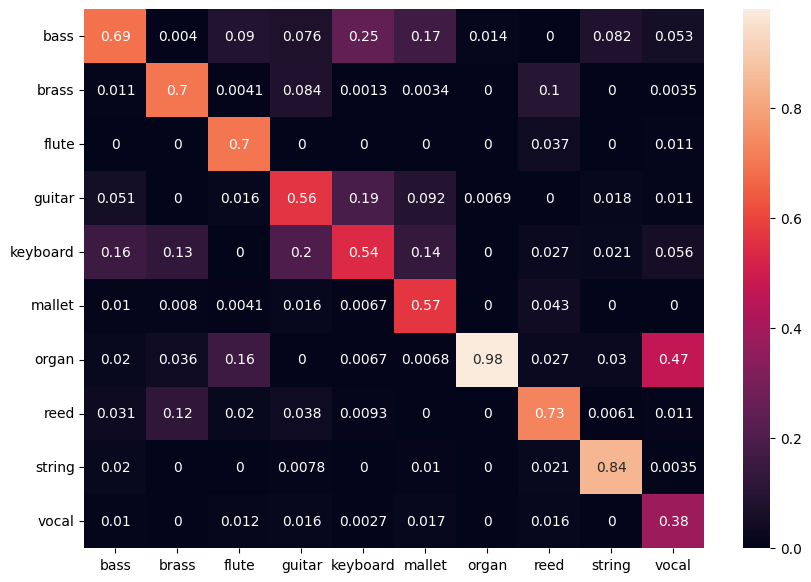

In [9]:
# Score trained model.
scores = model.evaluate(X_test_numpy, y_test_numpy, verbose=1)

y_prediction = model.predict(X_test_numpy)
y_prediction = np.argmax(y_prediction, axis = 1)

print(y_prediction)
print(y_test_confusion)

result = confusion_matrix(y_test_confusion, y_prediction , normalize='pred')

df_cm = pd.DataFrame(result, index = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]],
                  columns = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
print(model.metrics_names)
print(scores)

### Plot loss and accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


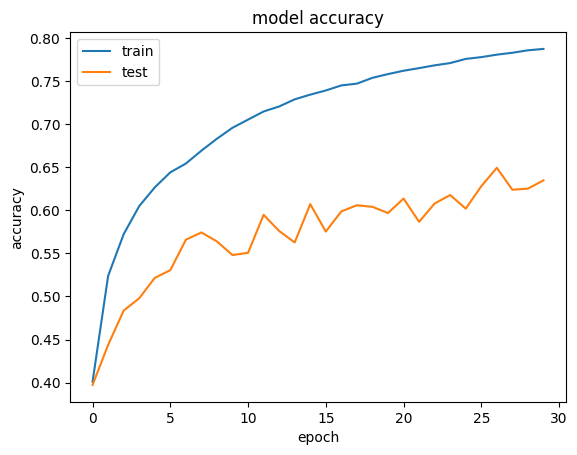

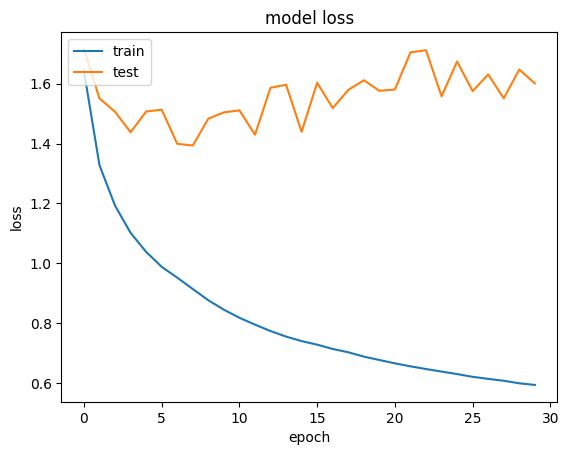

In [10]:

# list all data in history
print(history.history.keys())


# Taget från https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model and history

In [4]:
model_name = 'models/lstm_87500_126_13_30epochs.h5'
history_name = 'models/lstm_87500_126_13_30epochs-history'

model.save(model_name)
with open(history_name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

NameError: name 'model' is not defined

## Loading the model and history

In [5]:
model_name = 'models/lstm_87500_126_13_30epochs.h5'
history_name = 'models/lstm_87500_126_13_30epochs-history'

model = tf.keras.models.load_model('models/lstm_87500_126_13_30epochs.h5')

with open(history_name, 'rb') as f:
    history = pickle.load(f)

# Score trained model.
scores = model.evaluate(X_test_numpy, y_test_numpy, verbose=1)

y_prediction = model.predict(X_test_numpy)
y_prediction = np.argmax(y_prediction, axis = 1)
result = confusion_matrix(y_test_confusion, y_prediction , normalize='pred')
print(result.shape)

2023-04-26 22:22:03.803938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 22:22:03.808761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 22:22:03.808961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 22:22:03.809415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

128/128 [==============================] - 1s 4ms/step
(10, 10)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


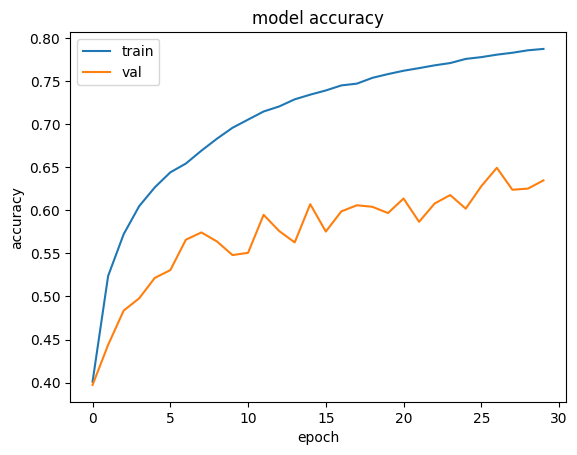

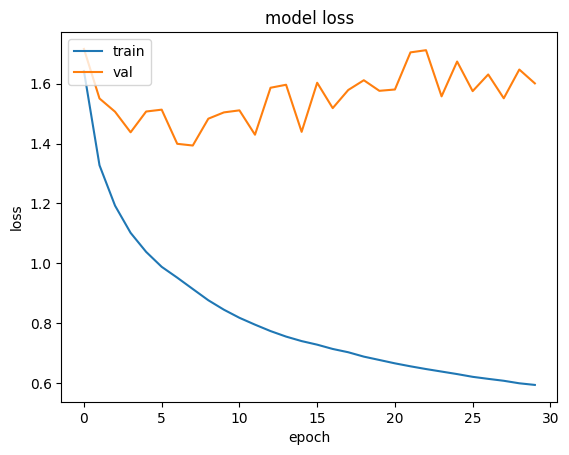

['loss', 'accuracy']
[1.6314194202423096, 0.64306640625]


<Figure size 640x480 with 0 Axes>

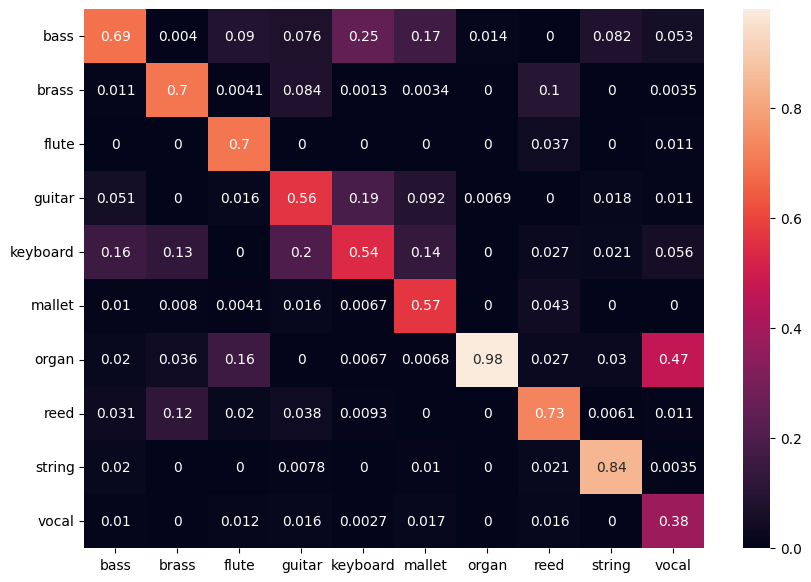

In [7]:
# list all data in history
print(history.keys())


# Taget från https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy_loss_plots/acc-lstm_87500_126_13_30epochs.png')
plt.show()


# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy_loss_plots/loss-lstm_87500_126_13_30epochs.png')
plt.show()


df_cm = pd.DataFrame(result, index = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]],
                  columns = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
print(model.metrics_names)
print(scores)

### Spara plot av modellen

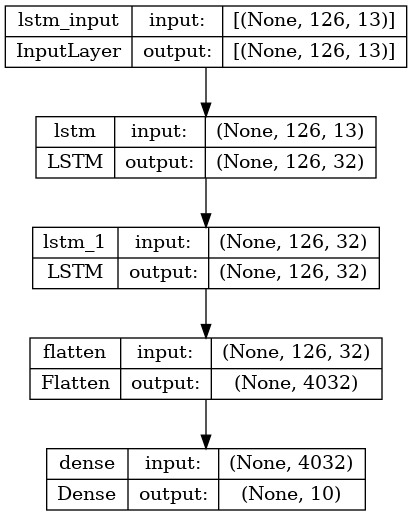

In [6]:
plot_model(model, to_file='model_plots/lstm_87500_126_13_30epochs.png', show_shapes=True, show_layer_names=True)